### Objective

In this notebook, we investigate combining PINN with symbolic regression to discover ODE systems. Our target ODE system can be written as follows:

\begin{align}
    \frac{du_1}{dt} &= e^{-t/10}u_2u_3 \\
    \frac{du_2}{dt} &= u_1u_3 \\
    \frac{du_3}{dt} &= -2u_1u_2 \\
\end{align}

with an initial condition of $u_1(0)=1, u_2(0)=0.8, u_3(0)=0.5$.

For our case study, we assume that we only know the right-hand side of the third equation to be a linear transformation of $u_1u_2$, and have no knowledge of the first two equations. Essentially, we can rewrite the ODE system as follows:

\begin{align}
    \frac{du_1}{dt} &= f_1(t, u_1, u_2, u_3) \\
    \frac{du_2}{dt} &= f_2(t, u_1, u_2, u_3) \\
    \frac{du_3}{dt} &= au_1u_2 + b \\
\end{align}

where $a, b$ are unknown coefficients and $f_1, f_2$ are the unknown functions. By using PINN and symbolic regression, we aim to calibrate the values of $a$ and $b$, as well as the functional forms of $f_1$ and $f_2$.

### 0. Import libraries

In [2]:
# Common packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from scipy.integrate import solve_ivp
from collections import defaultdict
import time

import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)

### 1. Observational data generation

To begin with, we need to generate simulation data of the investigated ODE system, which will be used later for inverse calibration.

In [3]:
def simulate_ODEs(u_init, t_span, obs_num):
    """Simulate the ODE system and obtain observational data.

    Args:
    ----
    u_init: list of initial condition for u1, u2, and u3
    t_span: lower and upper time limit for simulation
    obs_num: number of observational data points

    Outputs:
    --------
    u_obs: observed data for u's
    """

    # Define the target ODEs
    def odes(t, u):
        du1dt = np.exp(-t/10) * u[1] * u[2]
        du2dt = u[0] * u[2]
        du3dt = -2 * u[0] * u[1]
        return [du1dt, du2dt, du3dt]

    # Solve ODEs
    t_eval = np.linspace(t_span[0], t_span[1], obs_num)
    sol = solve_ivp(odes, t_span, u_init, method='RK45', t_eval=t_eval)

    # Restrcture obtained data
    u_obs = np.column_stack((sol.t, sol.y[0], sol.y[1], sol.y[2]))

    return u_obs

np.savetxt('u_obs.csv', u_obs, delimiter=',', header='t,y0,y1,y2', comments='')

In [4]:
# Set up simulation
u_init = [1, 0.8, 0.5]
t_span = [0, 10]
obs_num = 1000

# Solve ODEs
u_obs = simulate_ODEs(u_init, t_span, obs_num)

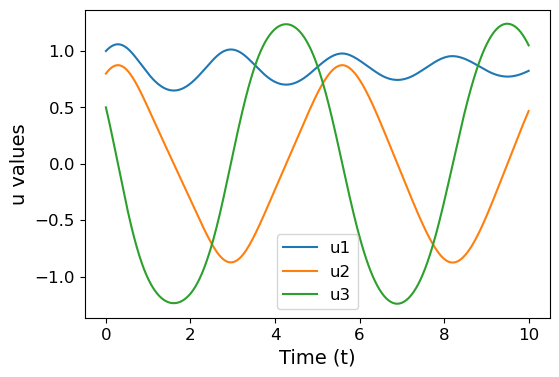

In [5]:
# Visualize the results
plt.figure(figsize=(6, 4))

plt.plot(u_obs[:, 0], u_obs[:, 1], label='u1')
plt.plot(u_obs[:, 0], u_obs[:, 2], label='u2')
plt.plot(u_obs[:, 0], u_obs[:, 3], label='u3')

plt.xlabel('Time (t)', fontsize=14)
plt.ylabel('u values', fontsize=14)
plt.tick_params(labelsize=12)
plt.legend(fontsize=12, frameon=True)

plt.savefig('u_profile.png', bbox_inches='tight', transparent=True)

### 2. Organize dataset

In [6]:
# Set batch size
data_batch_size = 100
ODE_batch_size = 1000

# Samples for enforcing data loss
X_train_data = tf.convert_to_tensor(u_obs[:, :1], dtype=tf.float32)
y_train_data = tf.convert_to_tensor(u_obs[:, 1:], dtype=tf.float32)
train_ds_data = tf.data.Dataset.from_tensor_slices((X_train_data, y_train_data))
train_ds_data = train_ds_data.shuffle(1000).batch(data_batch_size)

# Samples for enforcing ODE residual loss
N_collocation = 10000
X_train_ODE = tf.convert_to_tensor(np.linspace(0, 10, N_collocation).reshape(-1, 1), dtype=tf.float32)
train_ds_ODE = tf.data.Dataset.from_tensor_slices((X_train_ODE))
train_ds_ODE = train_ds_ODE.shuffle(10*N_collocation).batch(ODE_batch_size)

# Generate testing data
u_obs_test = simulate_ODEs(u_init, t_span, 5000)
X_test, y_test = u_obs_test[:, :1], u_obs_test[:, 1:]

### 3. Physics-informed Neural Networks

#### Define a custom layer for hosting unknown parameters

In [7]:
class ParameterLayer(tf.keras.layers.Layer):
    def __init__(self, a, b, trainable=True):
        super(ParameterLayer, self).__init__()
        self._a = tf.convert_to_tensor(a, dtype=tf.float32)
        self._b = tf.convert_to_tensor(b, dtype=tf.float32)
        self.trainable = trainable

    def build(self, input_shape):
        self.a = self.add_weight("a", shape=(1,),
                                 initializer=tf.keras.initializers.Constant(value=self._a),
                                 trainable=self.trainable)
        self.b = self.add_weight("b", shape=(1,),
                                 initializer=tf.keras.initializers.Constant(value=self._b),
                                 trainable=self.trainable)

    def get_config(self):
        return super().get_config()

    @classmethod
    def from_config(cls, config):
        return cls(**config)

#### Define Physics-informed Neural Network

In [8]:
def u_net(input_layer):
    """Definition of the network for u prediction."""

    hidden = input_layer
    for _ in range(2):
        hidden = tf.keras.layers.Dense(50, activation="tanh")(hidden)
    output = tf.keras.layers.Dense(3)(hidden)
    return output


def f_net(input_layers, a_init=None, b_init=None):
    """Definition of the network for f prediction."""

    hidden = tf.keras.layers.Concatenate()(input_layers)
    for _ in range(2):
        hidden = tf.keras.layers.Dense(50, activation="tanh")(hidden)
    output = tf.keras.layers.Dense(2)(hidden)
    output = ParameterLayer(a_init, b_init)(output)
    return output


def create_PINN(a_init=None, b_init=None, verbose=False):
    """Definition of a physics-informed neural network.

    Args:
    ----
    a_init: initial value for parameter a
    b_init: initial value for parameter b
    verbose: boolean, indicate whether to show the model summary

    Outputs:
    --------
    model: the PINN model
    """
    # Input
    t_input = tf.keras.Input(shape=(1,), name="time")

    # u-NN
    u = u_net(t_input)

    # f-NN
    f = f_net([t_input, u], a_init, b_init)

    # PINN model
    model = tf.keras.models.Model(inputs=t_input, outputs=[u, f])

    if verbose:
        model.summary()

    return model

#### ODE loss

In [9]:
@tf.function
def ODE_residual_calculator(t, model):
    """ODE residual calculation.

    Args:
    ----
    t: temporal coordinate
    model: PINN model

    Outputs:
    --------
    ODE_residual: residual of the governing ODE
    """

    # Retrieve parameters
    a = model.layers[-1].a
    b = model.layers[-1].b

    with tf.GradientTape() as tape:
        tape.watch(t)
        u, f = model(t)

    # Calculate gradients
    dudt = tape.batch_jacobian(u, t)[:, :, 0]
    du1_dt, du2_dt, du3_dt = dudt[:, :1], dudt[:, 1:2], dudt[:, 2:]

    # Compute residuals
    res1 = du1_dt - f[:, :1]
    res2 = du2_dt - f[:, 1:]
    res3 = du3_dt - (a*u[:, :1]*u[:, 1:2] + b)
    ODE_residual = tf.concat([res1, res2, res3], axis=1)

    return ODE_residual

#### Gradient descent step

In [10]:
@tf.function
def train_step(X_ODE, X, y, IC_weight, ODE_weight, data_weight, model):
    """Calculate gradients of the total loss with respect to network model parameters.

    Args:
    ----
    X_ODE: Collocation points for evaluating ODE residuals
    X: observed samples
    y: target values of the observed samples
    IC_weight: weight for initial condition loss
    ODE_weight: weight for ODE loss
    data_weight: weight for data loss
    model: PINN model

    Outputs:
    --------
    ODE_loss: calculated ODE loss
    IC_loss: calculated initial condition loss
    data_loss: calculated data loss
    total_loss: weighted sum of ODE loss, initial condition loss, and data loss
    gradients: gradients of the total loss with respect to network model parameters.
    """
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_weights)

        # Initial condition prediction
        y_pred_IC, _ = model(tf.zeros((1, 1)))

        # Equation residual
        ODE_residual = ODE_residual_calculator(t=X_ODE, model=model)

        # Data loss
        y_pred_data, _ = model(X)

        # Calculate loss
        IC_loss = tf.reduce_mean(keras.losses.mean_squared_error(tf.constant([[1.0, 0.8, 0.5]]), y_pred_IC))
        ODE_loss = tf.reduce_mean(tf.square(ODE_residual))
        data_loss = tf.reduce_mean(keras.losses.mean_squared_error(y, y_pred_data))

        # Weight loss
        total_loss = IC_loss*IC_weight + ODE_loss*ODE_weight + data_loss*data_weight

    gradients = tape.gradient(total_loss, model.trainable_variables)

    return ODE_loss, IC_loss, data_loss, total_loss, gradients

#### Define loss tracking class

In [11]:
class LossTracking:

    def __init__(self):
        self.mean_total_loss = keras.metrics.Mean()
        self.mean_IC_loss = keras.metrics.Mean()
        self.mean_ODE_loss = keras.metrics.Mean()
        self.mean_data_loss = keras.metrics.Mean()
        self.loss_history = defaultdict(list)

    def update(self, total_loss, IC_loss, ODE_loss, data_loss):
        self.mean_total_loss(total_loss)
        self.mean_IC_loss(IC_loss)
        self.mean_ODE_loss(ODE_loss)
        self.mean_data_loss(data_loss)

    def reset(self):
        self.mean_total_loss.reset_states()
        self.mean_IC_loss.reset_states()
        self.mean_ODE_loss.reset_states()
        self.mean_data_loss.reset_states()

    def print(self):
        print(f"IC={self.mean_IC_loss.result().numpy():.4e}, \
              ODE={self.mean_ODE_loss.result().numpy():.4e}, \
              data={self.mean_data_loss.result().numpy():.4e}, \
              total_loss={self.mean_total_loss.result().numpy():.4e}")

    def history(self):
        self.loss_history['total_loss'].append(self.mean_total_loss.result().numpy())
        self.loss_history['IC_loss'].append(self.mean_IC_loss.result().numpy())
        self.loss_history['ODE_loss'].append(self.mean_ODE_loss.result().numpy())
        self.loss_history['Data_loss'].append(self.mean_data_loss.result().numpy())

#### Define callback

In [12]:
class PrintParameters(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        print(f"\na: {self.model.layers[-1].a.numpy()}, b: {self.model.layers[-1].b.numpy()}")

#### Training

In [13]:
# Set up training configurations
n_epochs = 1000
IC_weight= tf.constant(1.0, dtype=tf.float32)
ODE_weight= tf.constant(1.0, dtype=tf.float32)
data_weight= tf.constant(1.0, dtype=tf.float32)
loss_tracker = LossTracking()
val_loss_hist = []
a_list, b_list = [], []

# Initial value for unknown parameters
a_init, b_init = -1, 1

# Set up optimizer
optimizer = keras.optimizers.Adam(learning_rate=2e-2)

with tf.device("CPU:0"):

    # Instantiate the PINN model
    PINN = create_PINN(a_init=a_init, b_init=b_init)
    PINN.compile(optimizer=optimizer)

    # Configure callbacks
    _callbacks = [keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=100),
                 tf.keras.callbacks.ModelCheckpoint('PINN_model.h5', monitor='val_loss', save_best_only=True),
                 PrintParameters()]
    callbacks = tf.keras.callbacks.CallbackList(
                    _callbacks, add_history=False, model=PINN)

    # Start training process
    for epoch in range(1, n_epochs + 1):
        print(f"Epoch {epoch}:")

        for (X_ODE), (X, y) in zip(train_ds_ODE, train_ds_data):

            # Calculate gradients
            ODE_loss, IC_loss, data_loss, total_loss, gradients = train_step(X_ODE, X, y, IC_weight,
                                                                             ODE_weight, data_weight, PINN)
            # Gradient descent
            PINN.optimizer.apply_gradients(zip(gradients, PINN.trainable_variables))

            # Loss tracking
            loss_tracker.update(total_loss, IC_loss, ODE_loss, data_loss)

        # Loss summary
        loss_tracker.history()
        loss_tracker.print()
        loss_tracker.reset()

        # Parameter recording
        a_list.append(PINN.layers[-1].a.numpy())
        b_list.append(PINN.layers[-1].b.numpy())

        ####### Validation
        val_res = ODE_residual_calculator(tf.reshape(tf.linspace(0.0, 10.0, 1000), [-1, 1]), PINN)
        val_ODE = tf.cast(tf.reduce_mean(tf.square(val_res)), tf.float32)

        u_init=tf.constant([[1.0, 0.8, 0.5]])
        val_pred_init, _ = PINN.predict(tf.zeros((1, 1)))
        val_IC = tf.reduce_mean(tf.square(val_pred_init - u_init))
        print(f"val_IC: {val_IC.numpy():.4e}, val_ODE: {val_ODE.numpy():.4e}, lr: {PINN.optimizer.lr.numpy():.2e}")

        # Callback at the end of epoch
        callbacks.on_epoch_end(epoch, logs={'val_loss': val_IC+val_ODE})
        val_loss_hist.append(val_IC+val_ODE)

        # Test dataset
        pred_test, _ = PINN.predict(X_test, batch_size=12800)
        print(f"RMSE: {mean_squared_error(y_test.flatten(), pred_test.flatten(), squared=False)}")


        # Re-shuffle dataset
        train_ds_data = tf.data.Dataset.from_tensor_slices((X_train_data, y_train_data))
        train_ds_data = train_ds_data.shuffle(10000).batch(data_batch_size)

        train_ds_ODE = tf.data.Dataset.from_tensor_slices((X_train_ODE))
        train_ds_ODE = train_ds_ODE.shuffle(10*N_collocation).batch(ODE_batch_size)

Epoch 1:
IC=2.5257e-01,               ODE=1.9693e+00,               data=1.6620e+00,               total_loss=3.8839e+00
1/1 [==============================] - 0s 132ms/step
val_IC: 3.2978e-02, val_ODE: 2.4988e-01, lr: 2.00e-02

a: [-0.8927994], b: [0.96172947]
1/1 [==============================] - 0s 26ms/step
RMSE: 1.0504931292558066
Epoch 2:
IC=5.1759e-02,               ODE=2.2260e-01,               data=6.4281e-01,               total_loss=9.1717e-01
1/1 [==============================] - 0s 24ms/step
val_IC: 5.2205e-02, val_ODE: 3.2405e-02, lr: 2.00e-02

a: [-0.86121154], b: [0.9035804]
1/1 [==============================] - 0s 35ms/step
RMSE: 0.7990323902359892
Epoch 3:
IC=4.1391e-02,               ODE=1.0428e-01,               data=5.2133e-01,               total_loss=6.6700e-01
1/1 [==============================] - 0s 22ms/step
val_IC: 3.9228e-02, val_ODE: 1.2087e-01, lr: 2.00e-02

a: [-0.8524965], b: [0.8363492]
1/1 [==============================] - 0s 29ms/step
RMSE: 0.667

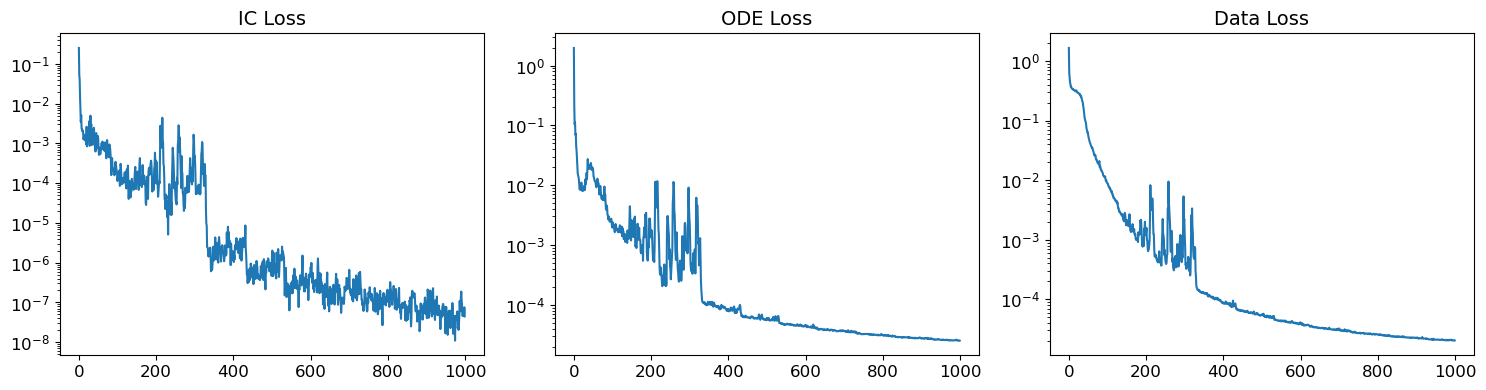

In [15]:
# History
#%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(range(n_epochs), loss_tracker.loss_history['IC_loss'])
ax[1].plot(range(n_epochs), loss_tracker.loss_history['ODE_loss'])
ax[2].plot(range(n_epochs), loss_tracker.loss_history['Data_loss'])
ax[0].set_title('IC Loss', fontsize=14)
ax[1].set_title('ODE Loss', fontsize=14)
ax[2].set_title('Data Loss', fontsize=14)
for axs in ax:
    axs.set_yscale('log')
    axs.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()

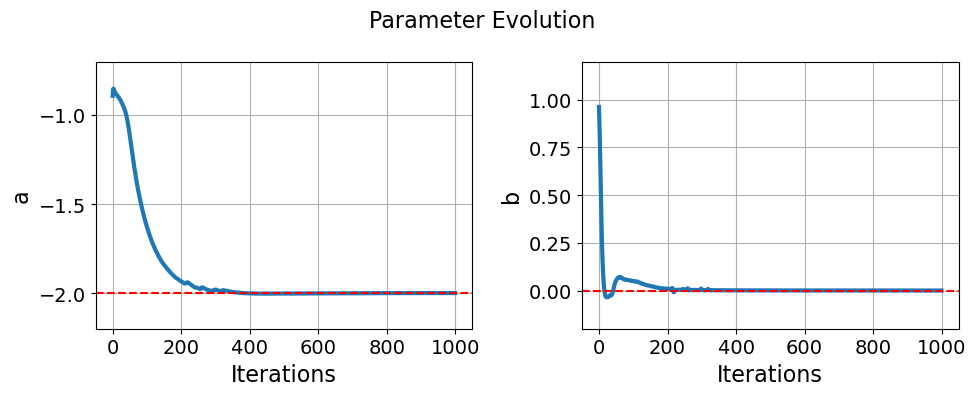

In [16]:
# Parameter history
#%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(range(n_epochs), a_list, lw=3)
ax[0].set_ylabel('a', fontsize=16)
ax[0].set_xlabel('Iterations', fontsize=16)
ax[0].set_ylim((-2.2, -0.7))
ax[0].axhline(y=-2, color='r', linestyle='--')

ax[1].plot(range(n_epochs), b_list, lw=3)
ax[1].set_ylabel('b', fontsize=16)
ax[1].set_xlabel('Iterations', fontsize=16)
ax[1].set_ylim((-0.2, 1.2))
ax[1].axhline(y=0, color='r', linestyle='--')

for axs in ax:
    axs.tick_params(axis='both', which='major', labelsize=14)
    axs.grid(True)
fig.suptitle('Parameter Evolution', fontsize=16)
plt.tight_layout()

#### Collect input/output of f-NN

In [17]:
t = np.linspace(0, 10, 10000).reshape(-1, 1)
u, f = PINN.predict(t, batch_size=12800)

# Configure dataframe
df = pd.DataFrame({
    't': t.flatten(),
    'u1': u[:, 0],
    'u2': u[:, 1],
    'u3': u[:, 2],
    'f1': f[:, 0],
    'f2': f[:, 1]
})
df.to_csv('f_NN_IO.csv', index=False)

1/1 [==============================] - 0s 63ms/step


Text(0.5, 1.0, 'f2')

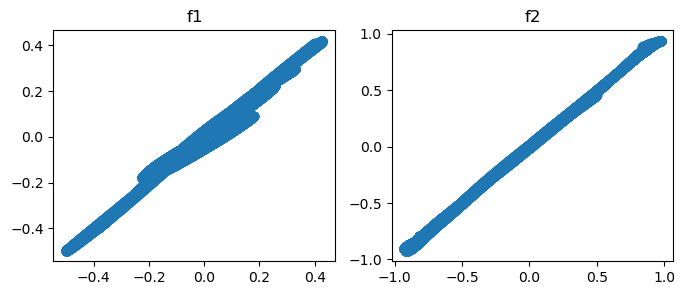

In [18]:
# Sanity check
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].scatter(np.exp(-df.t.values/10)*df.u2.values*df.u3.values, df.f1)
ax[0].set_title('f1')

ax[1].scatter(df.u1.values*df.u3.values, df.f2)
ax[1].set_title('f2')

#### Assess accuracy: u prediction

In [19]:
t = np.linspace(0, 10, 5000).reshape(-1, 1)
pred_u, pred_f = PINN.predict(t, batch_size=12800)

1/1 [==============================] - 0s 25ms/step


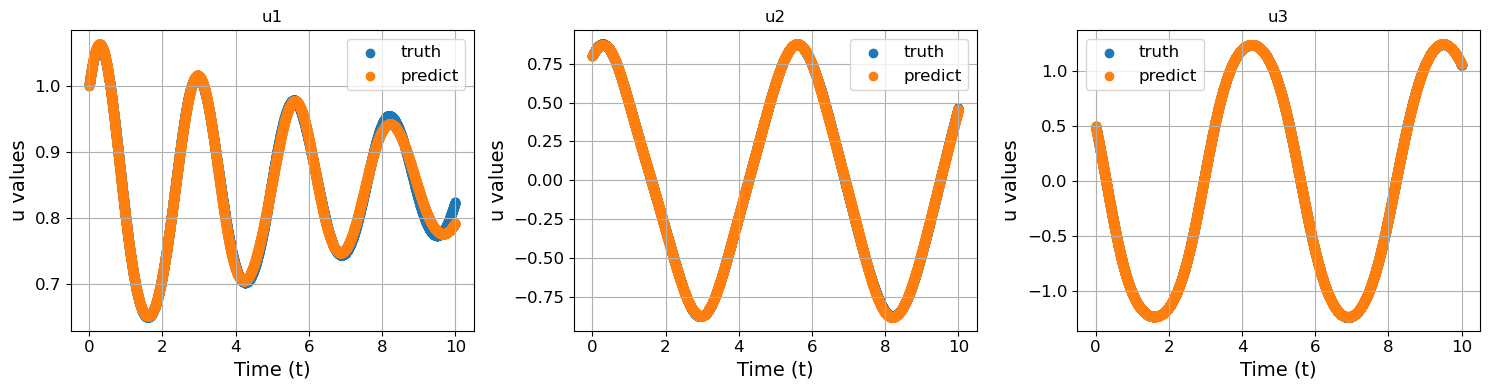

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].scatter(t.flatten(), y_test[:, 0], label='truth')
ax[0].scatter(t.flatten(), pred_u[:, 0], label='predict')
ax[0].set_title('u1')
ax[1].scatter(t.flatten(), y_test[:, 1], label='truth')
ax[1].scatter(t.flatten(), pred_u[:, 1], label='predict')
ax[1].set_title('u2')
ax[2].scatter(t.flatten(), y_test[:, 2], label='truth')
ax[2].scatter(t.flatten(), pred_u[:, 2], label='predict')
ax[2].set_title('u3')

for axs in ax:
    axs.set_xlabel('Time (t)', fontsize=14)
    axs.set_ylabel('u values', fontsize=14)
    axs.tick_params(axis='both', which='major', labelsize=12)
    axs.legend(fontsize=12, frameon=True)
    axs.grid(True)

plt.tight_layout()

#### Access accuracy: f prediction

In [21]:
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(X_test)
    u, f = PINN(X_test)

# Calculate gradients
dudt = tape.batch_jacobian(u, X_test)[:, :, 0]
du1_dt, du2_dt, du3_dt = dudt[:, :1], dudt[:, 1:2], dudt[:, 2:]

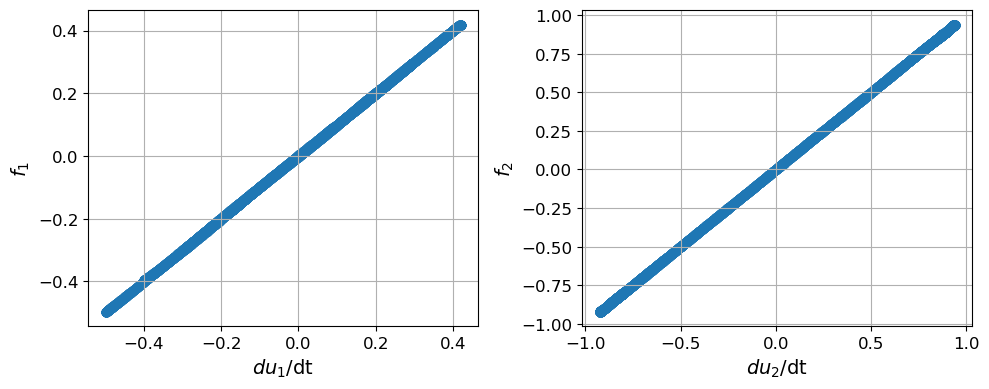

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(du1_dt.numpy().flatten(), f[:, 0].numpy())
ax[0].set_xlabel('$du_1$/dt', fontsize=14)
ax[0].set_ylabel('$f_1$', fontsize=14)
ax[1].scatter(du2_dt.numpy().flatten(), f[:, 1].numpy())
ax[1].set_xlabel('$du_2$/dt', fontsize=14)
ax[1].set_ylabel('$f_2$', fontsize=14)

for axs in ax:
    axs.tick_params(axis='both', which='major', labelsize=12)
    axs.grid(True)

plt.tight_layout()

In [25]:
from pysr import PySRRegressor

[juliapkg] Found dependencies: c:\users\hanno\anaconda3\lib\site-packages\pysr\juliapkg.json
[juliapkg] Found dependencies: c:\users\hanno\anaconda3\lib\site-packages\juliacall\juliapkg.json
[juliapkg] Found dependencies: c:\users\hanno\anaconda3\lib\site-packages\juliapkg\juliapkg.json
[juliapkg] Locating Julia ~1.6.7, ~1.7, ~1.8, ~1.9, =1.10.0, ^1.10.3
[juliapkg] Querying Julia versions from https://julialang-s3.julialang.org/bin/versions.json
[juliapkg] WARNING: About to install Julia 1.10.3 to C:\Users\hanno\Anaconda3\julia_env\pyjuliapkg\install.
[juliapkg]   If you use juliapkg in more than one environment, you are likely to
[juliapkg]   have Julia installed in multiple locations. It is recommended to
[juliapkg]   install JuliaUp (https://github.com/JuliaLang/juliaup) or Julia
[juliapkg]   (https://julialang.org/downloads) yourself.
[juliapkg] Downloading Julia from https://julialang-s3.julialang.org/bin/winnt/x64/1.10/julia-1.10.3-win64.zip
             downloaded 130.9 MB of 16

KeyboardInterrupt: 

In [24]:
pip install pysr

     ---------------------------------------- 0.0/76.3 kB ? eta -:--:--
     ---------------------------------------- 76.3/76.3 kB 4.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/5.7 MB ? eta -:--:--
     - -------------------------------------- 0.2/5.7 MB 3.5 MB/s eta 0:00:02
     ------- -------------------------------- 1.1/5.7 MB 11.3 MB/s eta 0:00:01
     ----------------- ---------------------- 2.5/5.7 MB 17.7 MB/s eta 0:00:01
     -------------------------- ------------- 3.7/5.7 MB 19.9 MB/s eta 0:00:01
     ------------------------------------ --- 5.2/5.7 MB 23.8 MB/s eta 0:00:01
     ---------------------------------------- 5.7/5.7 MB 21.6 MB/s eta 0:00:00
     ---------------------------------------- 0.0/536.2 kB ? eta -:--:--
     ------------------------------------- 536.2/536.2 kB 32.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [26]:
from pysr import PySRRegressor

model = PySRRegressor(
    niterations=20,
    binary_operators=["+", "*"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
        "inv(x) = 1/x",
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    loss="L1DistLoss()",
    model_selection="score",
    complexity_of_operators={
        "sin": 3, "cos": 3, "exp": 3,
        "inv(x) = 1/x": 3
    }
)

[juliapkg] Found dependencies: c:\users\hanno\anaconda3\lib\site-packages\pysr\juliapkg.json
[juliapkg] Found dependencies: c:\users\hanno\anaconda3\lib\site-packages\juliacall\juliapkg.json
[juliapkg] Found dependencies: c:\users\hanno\anaconda3\lib\site-packages\juliapkg\juliapkg.json
[juliapkg] Locating Julia ~1.6.7, ~1.7, ~1.8, ~1.9, =1.10.0, ^1.10.3
[juliapkg] Using Julia 1.10.3 at C:\Users\hanno\Anaconda3\julia_env\pyjuliapkg\install\bin\julia.exe
[juliapkg] Using Julia project at C:\Users\hanno\Anaconda3\julia_env
[juliapkg] Installing packages:
           julia> import Pkg
           julia> Pkg.Registry.update()
           julia> Pkg.add([Pkg.PackageSpec(name="SymbolicRegression", uuid="8254be44-1295-4e6a-a16d-46603ac705cb"), Pkg.PackageSpec(name="Serialization", uuid="9e88b42a-f829-5b0c-bbe9-9e923198166b"), Pkg.PackageSpec(name="PythonCall", uuid="6099a3de-0909-46bc-b1f4-468b9a2dfc0d")])
           julia> Pkg.resolve()
           julia> Pkg.precompile()
Detected IPython. Loadi

c:\Users\hanno\Anaconda3\lib\site-packages\pysr\sr.py:870: FutureWarning: loss has been renamed to elementwise_loss in PySRRegressor. Please use that instead.
  warnings.warn(


In [27]:
t = np.linspace(0, 10, 10000).reshape(-1, 1)
u, f = PINN.predict(t, batch_size=12800)

# Configure dataframe
df = pd.DataFrame({
    't': t.flatten(),
    'u1': u[:, 0],
    'u2': u[:, 1],
    'u3': u[:, 2],
    'f1': f[:, 0],
    'f2': f[:, 1]
})
df.to_csv('f_NN_IO.csv', index=False)

1/1 [==============================] - 0s 187ms/step


In [28]:
df = pd.read_csv('f_NN_IO.csv')
X = df.iloc[:, :4].to_numpy()
f1 = df.loc[:, 'f1'].to_numpy()

model.fit(X, f1)

c:\Users\hanno\Anaconda3\lib\site-packages\pysr\sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 1.080e+04
Head worker occupation: 4.9%
Progress: 22 / 300 total iterations (7.333%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
3           1.340e-01  5.314e+00  y = x₂ * x₃
5           6.290e-02  3.782e-01  y = (0.59398 * x₃) * x₂
7           6.255e-02  2.823e-03  y = ((x₂ * 0.77242) * 0.7392) * x₃
8           6.253e-02  1.990e-04  y = (x₃ * cos(-0.96869)) * x₂
10          6.243e-02  8.423e-04  y = sin((0.50831 * (1.1284 * x₃)) * x₂)
11          6.240e-02  5.216e-04  y = sin(sin(0.63554) * x₃) * x₂
13          6.206e-02  2.734e-03  y = sin(cos(-0.95971) * ((x₃ * x₂) + 0.011625))
14          6.203e-02  4.389e-04  y = sin(sin(x₃ * x₂)) * cos(-0.9215)
17          6.120e-02  4.506e-03  y = sin(((cos(0.83496) + ((x₃ * -0.15175) * 0.81199)) * x₃) * ...
                                  x₂)
---------------------------------------------------------

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                       -0.022676997   
	1         0.206009                                            x2 * x3   
	2         0.381101                              x3 * (x2 * 0.5662795)   
	3         0.001257             ((x2 + -0.011214935) * x3) * 0.5737905   
	4         0.002456                           0.5879142 * sin(x3 * x2)   
	5   >>>>  0.664267              (x2 * x3) * (x1 + (-0.05029917 * x0))   
	6         0.131590  ((x3 * (1.0447874 + (x0 * -0.07297969))) * x2)...   
	7         0.510177  sin(((1.0061926 + (x0 * -0.07830825)) * x3) * x2)   
	8         0.007203  -0.001334074 + (x2 * (((-0.074239954 * x0) + c...   
	9         0.000343  -0.0011229133 + (x2 * (((-0.07407269 * x0) + c...   
	10        0.006679  sin((x3 * (sin(x1 + 0.6569027) + (x0 * -0.0767...   
	11        0.076787  (-0.001334074 * (x3 * x0)) + (x2 * (((x0 * -0....   
	12        0.004922  ((-0.001334074 * x0) * x3) + (x2 * ((cos(0.176...   
	
	        loss  complexity  
	0   0.202335           1  
	1   0.134009           3  
	2   0.062534           5  
	3   0.062377           7  
	4   0.062224           8  
	5   0.032024           9  
	6   0.024613          11  
	7   0.014778          12  
	8   0.014566          14  
	9   0.014556          16  
	10  0.014459          17  
	11  0.013391          18  
	12  0.013259          20  
]